# Figure 5: BVEP

In [1]:
#%%
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from tqdm.auto import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
from loss_cal.tasks.bvep import BVEP
from loss_cal.npe import load_npes
from loss_cal.predictor import load_predictors
from loss_cal.costs import (
    MultiClass01Cost,
    MultiClassStepCost,
    expected_posterior_costs_given_posterior_samples,
)
from loss_cal.utils.analysis import find_optimal_action
from sbi.analysis import pairplot


plot_config_file = "loss_cal/utils/.matplotlibrc"
plt.rcParams.update(mpl.rc_params_from_file(fname=plot_config_file))

color_npe = "#377eb8"
color_nn = "#ff7f00"
color_post = "#4daf4a"
save_dir = "./paper/fig5/"

seed = 3498 #76248
torch.manual_seed(seed)
from sbi.utils.sbiutils import seed_all_backends
seed_all_backends(seed)

### Task

In [ ]:
action_type="discrete"
num_actions=3
actions = torch.arange(3)
bvep = BVEP(action_type=action_type, num_actions=num_actions, simulator="2D")

task_name = bvep.task_name
prior = bvep.get_prior()
simulator = bvep.get_simulator()
simulator_nosummstats = bvep.simulator2D()
simulator6d = bvep.simulator6D()

#### Cost Function

In [4]:
param = 0
eta_crit = -2.05
eta_diff = 1.0
cost_fn = MultiClass01Cost(theta_crit=torch.Tensor([eta_crit-eta_diff, eta_crit, bvep.param_high[0].item()]))
# factors = torch.ones(3,3)
# factors[0,2] = 10
# cost_fn = MultiClassStepCost(theta_crit=torch.Tensor([eta_crit-eta_diff, eta_crit]), factors=factors)

theta_crit extended:  tensor([-4.2950e+09, -3.0500e+00, -2.0500e+00,  0.0000e+00,  4.2950e+09])


## Load Predictors

In [5]:
seeds = [0, 54, 943]

#### Load NPE

In [ ]:
flow = "maf"
npe_posteriors_allseeds = []
for s in seeds:
    npe_posteriors, num_simulations_npe = load_npes(f"./results/{bvep.task_name}/npe/{s}/", flow=flow)
    npe_posteriors_allseeds.append(npe_posteriors)

#### Load NN

In [ ]:
experiment = "vary_sim"
num_action_samples = "inloop"
models_allseeds = []
for s in seeds:
    dir = f"./results/{task_name}/{action_type}/nn/fc/{experiment}/{s}/{num_action_samples}/*_param_0_threshold_-3_05_-2_05_costs_1_1"
    #dir = f"./results/{task_name}/{action_type}/nn/fc/{experiment}/{s}/{num_action_samples}/asymmetric/*_param_0_threshold_-3_05_-2_05_costs_1_1"
    task_specifications = {"simulator": "2D", "action_type": action_type, "num_actions": num_actions, "probs": None}
    models, num_simulations_nn = load_predictors(
        task_name, dir=dir, data_dir="./data/bvep/Epileptor2D_summstats/", **task_specifications
    )
    models_allseeds.append(models)

In [8]:
num_simulations = 1000

nn = models_allseeds[0][num_simulations_nn.index(num_simulations)]
npe_posterior = npe_posteriors_allseeds[0][num_simulations_npe.index(num_simulations)]

## Panel A: Posterior Predictives (4, 3.5)

In [9]:
def plot_observations(observations, time_steps, prediction= None):
    col_min = 2
    num_colors = observations.shape[0]+col_min
    cm1 = mpl.cm.Blues
    col1 = [cm1(1.*i/num_colors) for i in range(col_min,num_colors)]


    fig = plt.figure(figsize=(10,6))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    ax = plt.subplot(gs[0])
    for i in range(observations.shape[0]):
        plt.plot(time_steps,observations[i,:],color=color_post, alpha = (i+1)/(num_colors+1), lw=2) #col1[i], lw=2) #, label=f'eta={true_params[0]:.1f}')

    if prediction is not None:
        plt.plot(time_steps, prediction, color=color_npe, lw=2)
    plt.ylabel('fast-variable (x)', fontsize=18); 
    plt.xlabel('Time')
    plt.legend(loc='upper right')
    plt.ylim(-2.5,1.)
    ax.set_xticks([0, max(time_steps)/2, max(time_steps)])
    ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
    plt.tight_layout()
    plt.show()

In [ ]:
prior_samples = prior.sample((10,))
simulations = torch.vstack([simulator(theta) for theta in prior_samples])

In [11]:
num_p = 3
num_postpred = 3
# time step
T = 100.0
dt = 0.1
ts = torch.arange(0, T + dt, dt)
labels_params = [r'$\eta$', r'$\tau$', r'$x_{init}$', r'$z_{init}$']

### Healthy Zone (HZ)

In [12]:
# params: (eta, tau, x0, z0)
true_params_hz = torch.tensor([-3., 10., -2.5, 3.5])
true_params_hz.shape

torch.Size([4])

In [ ]:
obs_summstats_hz = []
obs_raw_hz = []
for i in range(num_p):
    single_obs_summstats, single_obs_raw = bvep.simulator2Dsummstats(return_raw=True)(true_params_hz)
    obs_summstats_hz.append(torch.Tensor(single_obs_summstats))
    obs_raw_hz.append(torch.Tensor(single_obs_raw[:ts.shape[0]]))

obs_summstats_hz = torch.stack(obs_summstats_hz)
obs_raw_hz = torch.stack(obs_raw_hz)

In [14]:
num_samples=1000
idx_sample = 0
posterior_samples_hz = npe_posterior.sample((num_samples,), obs_summstats_hz[idx_sample]) #only take one ismulation to condition the posterior
print("conditioned on only one of the observations - should this be done differently???")

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

conditioned on only one of the observations - should this be done differently???


#### NPE Posterior

In [15]:
bvep.prior_params

{'low': tensor([-5.0000,  0.1000, -5.0000,  0.0000]),
 'high': tensor([ 0., 50.,  0.,  5.])}

In [16]:
true_params_hz

tensor([-3.0000, 10.0000, -2.5000,  3.5000])

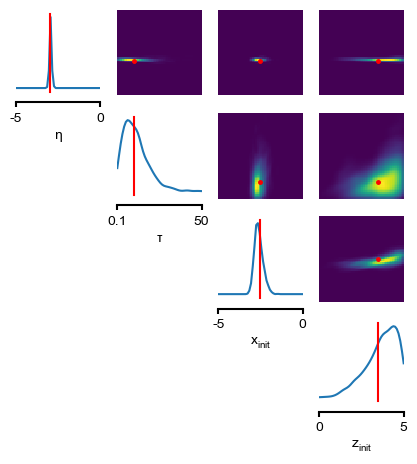

In [17]:
fig, axes = pairplot(
    samples=posterior_samples_hz,
    labels=labels_params,
    figsize=(5,5),
    upper=["kde"],
    diag=["kde"],
    points=true_params_hz,
    points_offdiag={"markersize": 5},
    points_colors="r",
    ticks=[[l,h] for l,h in zip(bvep.prior_params["low"], bvep.prior_params["high"])], #[[-5., -3., 0.], [0.1, 10., 50.], [-5., -2.5, 0.], [0., 3.5, 5.]],
    limits=[[l,h] for l,h in zip(bvep.prior_params["low"], bvep.prior_params["high"])]
)
# plt.tight_layout()
plt.savefig('./paper/fig5/posterior_hz.svg')
plt.show()

#### Observations and NPE Predictions

In [ ]:
posterior_predictives_hz = torch.empty((num_postpred,ts.shape[0]))
for i in range(num_postpred):
    _, posterior_predictive_hz = bvep.simulator2Dsummstats(return_raw=True)(posterior_samples_hz[i]) #(torch.quantile(posterior_samples_hz, q=0.5, dim=0))
    posterior_predictives_hz[i] = torch.Tensor(posterior_predictive_hz)

In [19]:
# plot_observations(observations=obs_raw_hz, time_steps=ts, prediction = posterior_predictives_hz[0])

### Propagation Zone (PZ)

In [ ]:
# params: (eta, tau, x0, z0)
true_params_pz = torch.tensor([-2.1, 10., -2.5, 3.5]) #check values again!!
true_params_pz.shape

obs_summstats_pz = []
obs_raw_pz = []
for i in range(num_p):
    single_obs_summstats, single_obs_raw = bvep.simulator2Dsummstats(return_raw=True)(true_params_pz)
    obs_summstats_pz.append(torch.Tensor(single_obs_summstats))
    obs_raw_pz.append(torch.Tensor(single_obs_raw[:ts.shape[0]]))

obs_summstats_pz = torch.stack(obs_summstats_pz)
obs_raw_pz = torch.stack(obs_raw_pz)

In [21]:
num_samples=1000
idx_sample = 0
posterior_samples_pz = npe_posterior.sample((num_samples,), obs_summstats_pz[idx_sample]) #only take one ismulation to condition the posterior
print("conditioned on only one of the observations - should this be done differently???")

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

conditioned on only one of the observations - should this be done differently???


#### NPE posterior

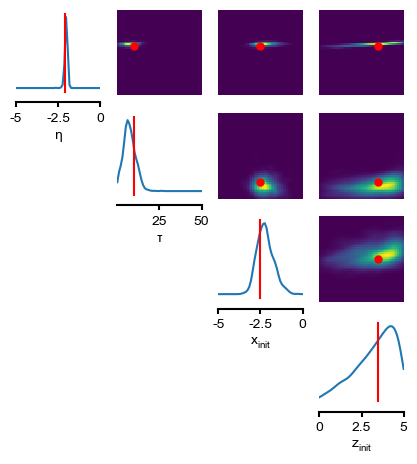

In [22]:
fig, axes = pairplot(
    samples=posterior_samples_pz,
    labels=labels_params,
    figsize=(5,5),
    upper=["kde"],
    diag=["kde"],
    points=true_params_pz,
    points_offdiag={"markersize": 10},
    points_colors="r",
    limits=[[l,h] for l,h in zip(bvep.prior_params["low"], bvep.prior_params["high"])]
)
# plt.tight_layout()
plt.show()

#### Observations and NPE Predictions

In [ ]:
posterior_predictives_pz = torch.empty((num_postpred,ts.shape[0]))
for i in range(num_postpred):
    _, posterior_predictive_pz = bvep.simulator2Dsummstats(return_raw=True)(posterior_samples_pz[i]) #(torch.quantile(posterior_samples_pz, q=0.5, dim=0))
    posterior_predictives_pz[i] = torch.Tensor(posterior_predictive_pz)

In [24]:
# plot_observations(observations=obs_raw_pz, time_steps=ts, prediction = posterior_predictive_pz)

### Epileptogenic Zone (EZ)

In [ ]:
# params: (eta, tau, x0, z0)
true_params_ez = torch.tensor([-1.5, 10., -2.5, 3.5]) #check values again!!
true_params_ez.shape

obs_summstats_ez = []
obs_raw_ez = []
for i in range(num_p):
    single_obs_summstats, single_obs_raw = bvep.simulator2Dsummstats(return_raw=True)(true_params_ez)
    obs_summstats_ez.append(torch.Tensor(single_obs_summstats))
    obs_raw_ez.append(torch.Tensor(single_obs_raw[:ts.shape[0]]))

obs_summstats_ez = torch.stack(obs_summstats_ez)
obs_raw_ez = torch.stack(obs_raw_ez)

In [26]:
num_samples=1000
idx_sample = 0
posterior_samples_ez = npe_posterior.sample((num_samples,), obs_summstats_ez[idx_sample]) #only take one ismulation to condition the posterior
print("conditioned on only one of the observations - should this be done differently???")

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

conditioned on only one of the observations - should this be done differently???


#### NPE posterior

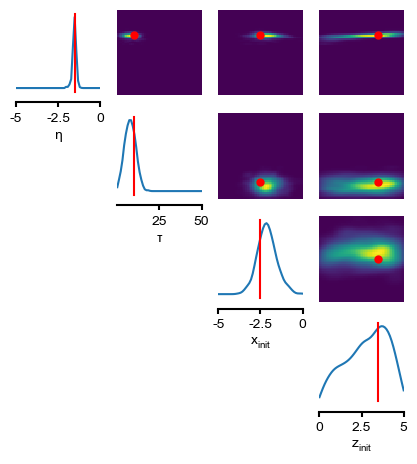

In [27]:
fig, axes = pairplot(
    samples=posterior_samples_ez,
    labels=labels_params,
    figsize=(5,5),
    upper=["kde"],
    diag=["kde"],
    points=true_params_ez,
    points_offdiag={"markersize": 10},
    points_colors="r",
    limits=[[l,h] for l,h in zip(bvep.prior_params["low"], bvep.prior_params["high"])]
)
# plt.tight_layout()
plt.show()

#### Observations and NPE Predictions

In [ ]:
posterior_predictives_ez = torch.empty((num_postpred,ts.shape[0]))
for i in range(num_postpred):
    _, posterior_predictive_ez = bvep.simulator2Dsummstats(return_raw=True)(posterior_samples_ez[i]) #(torch.quantile(posterior_samples_ez, q=0.5, dim=0))
    posterior_predictives_ez[i] = torch.Tensor(posterior_predictive_ez)

In [29]:
# plot_observations(observations=obs_raw_ez, time_steps=ts, prediction = posterior_predictive_ez)

### Panel Plot: All Predictions in one plot

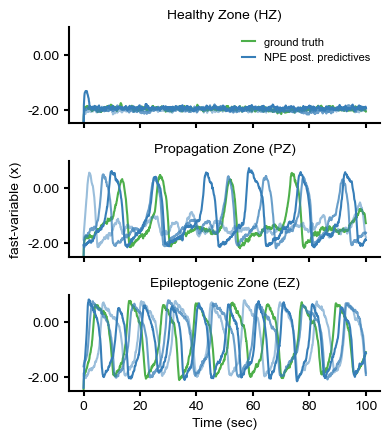

In [77]:
col_min = 2
num_colors = obs_raw_hz.shape[0] + col_min
num_colors_pp = posterior_predictives_hz.shape[0] 

cm1 = mpl.cm.Blues
col1 = [cm1(1.0 * i / num_colors) for i in range(col_min, num_colors)]


# fig, axes = plt.subplots(3, 1, figsize=(4, 4.305), sharey=True, sharex=True)
fig, axes = plt.subplots(3, 1, figsize=(4, 4.505), sharey=True, sharex=True)
axes[0].set_xticks(torch.arange(0, max(ts)+0.01, step = max(ts)//5))
axes[0].set_ylim(-2.5, 1.0)
axes[1].set_ylabel("fast-variable (x)")
axes[2].set_xlabel("Time (sec)")
axes[0].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.2f"))

for row, (observations, predictions, title) in enumerate(
    [
        (obs_raw_hz, posterior_predictives_hz, "Healthy Zone (HZ)"),
        (obs_raw_pz, posterior_predictives_pz, "Propagation Zone (PZ)"),
        (obs_raw_ez, posterior_predictives_ez, "Epileptogenic Zone (EZ)"),
    ]
):
    
    axes[row].set_title(title)
    for i in range(1): # range(observations.shape[0]):
        axes[row].plot(
            ts,
            observations[i, :],
            color=color_post,
            #alpha=(i + 1) / (num_colors + 1),
            label="ground truth"
        ) 
    for j in range(predictions.shape[0]):
        axes[row].plot(ts, predictions[j, :], color=color_npe, alpha=(j + 2) / (num_colors_pp + 1), label="NPE post. predictives")


handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend([handles[i], handles[-1]], [labels[i], labels[-1]],  loc="upper right", handlelength=1.15, fontsize="8")

plt.tight_layout()
plt.savefig('./paper/fig5/panel_a.svg')
plt.show()

## Panel C: Posterior Estimate

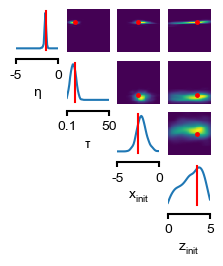

In [31]:
fig, axes = pairplot(
    samples=posterior_samples_ez,
    labels=labels_params,
    figsize=(2.5,2.5),
    upper=["kde"],
    diag=["kde"],
    points=true_params_ez,
    points_offdiag={"markersize": 5},
    points_colors="r",
    ticks = [[l,h] for l,h in zip(bvep.prior_params["low"], bvep.prior_params["high"])],
    limits=[[l,h] for l,h in zip(bvep.prior_params["low"], bvep.prior_params["high"])]
)
# plt.tight_layout()
plt.savefig('./paper/fig5/panel_c.svg')
plt.show()

## Panel B: Cost Function

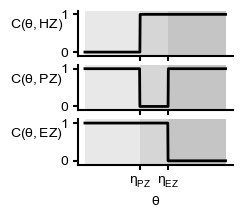

In [65]:
fig, axes = plt.subplots(3, 1, figsize=(2, 2), sharey=True, sharex=True)
plot_thetas = torch.arange(-5., 0., 0.01)
costs = torch.vstack([cost_fn(th, torch.Tensor([0., 1., 2.])) for th in plot_thetas.unsqueeze(1)]) #runs for single theta,  multiple a
col_min = 2
cm1 = mpl.cm.Greys
col1 = [cm1(1.*i/num_colors) for i in range(col_min,num_actions+col_min)]
color_hz = col1[0] #'C2'
color_pz = col1[1] #'C0'
color_ez = col1[2] #'C1'

axes[0].set_ylim(-0.1, 1.1)
axes[0].plot(plot_thetas, costs[:, 0], color='k', linewidth=2)#, linestyle='--', dashes=(3, 1))
axes[1].plot(plot_thetas, costs[:, 1], color='k', linewidth=2)#, linestyle='--', dashes=(3, 1))
axes[2].plot(plot_thetas, costs[:, 2], color='k', linewidth=2)#, linestyle='--', dashes=(3, 1))

# axes[2].text(-4.2,0.5, "HZ", color='k')
# axes[2].text(-2.8,0.5, "PZ", color='k')
# axes[2].text(-1.4,0.5, "EZ", color='k')
for r, label in enumerate(["HZ", "PZ", "EZ"]):
    axes[r].axvspan(-5.,eta_crit-eta_diff, facecolor=color_hz, alpha=0.3)# label="HZ")
    axes[r].axvspan(eta_crit-eta_diff, eta_crit, facecolor=color_pz, alpha=0.3)#, label="PZ")
    axes[r].axvspan(eta_crit, 0.,  facecolor=color_ez, alpha=0.3)#, label="EZ")
    axes[r].set_ylabel(fr"$C(\theta,{label})$", rotation=0, labelpad=17)

axes[2].set_xlabel(r"$\theta$")
axes[2].set_xticks([eta_crit, eta_crit-eta_diff], [r"$\eta_{EZ}$", r"$\eta_{PZ}$"])
plt.savefig('./paper/fig5/panel_b.svg')
plt.show()

## Panel D: Predictions on new data

In [38]:
generate_new_dataset = False
if generate_new_dataset:
    torch.manual_seed(seed)
    num_new = 1000
    theta_new = prior.sample((num_new,))
    observations_new = torch.vstack([simulator(theta) for theta in theta_new])
    # torch.save(theta_new, './paper/fig5/data/theta_new.pt')
    # torch.save(observations_new, './paper/fig5/data/observations_new.pt')
else:
    theta_new = torch.load('./paper/fig5/data/theta_new.pt')
    observations_new = torch.load('./paper/fig5/data/observations_new.pt')
    num_new = theta_new.shape[0]
gt_actions = ((theta_new[:, 0] > eta_crit-eta_diff).float() + (theta_new[:, 0] > eta_crit).float()).unsqueeze(1)
#gt_actions[:20]

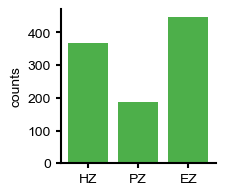

In [39]:
values_true, counts_true = torch.unique(gt_actions, return_counts=True)
fig, ax = plt.subplots(1,1, figsize=(2,2))
plt.bar(["HZ","PZ","EZ"], counts_true, color=color_post)
plt.ylabel("counts")
plt.show()

#### Predictions of NN

In [40]:
nn_optimal_action = []
for i, s in enumerate(seeds):
    nn = models_allseeds[i][num_simulations_nn.index(num_simulations)]
    nn_predictions_all_actions_seed = torch.hstack([nn(observations_new.to(torch.float32), a*torch.ones((observations_new.shape[0],1))).detach() for a in [0., 1., 2.]])
    nn_optimal_action_seed = nn_predictions_all_actions_seed.argmin(dim=1).float().unsqueeze(1)
    nn_optimal_action.append(nn_optimal_action_seed)

# majority vote for decision
nn_optimal_action, _ = torch.stack(nn_optimal_action).mode(dim=0)

In [41]:
(nn_optimal_action == gt_actions).sum()/num_new

tensor(0.9760)

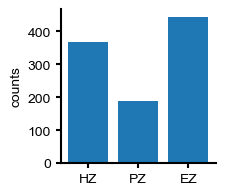

In [42]:
values_nn, counts_nn = torch.unique(nn_optimal_action, return_counts=True)
fig, ax = plt.subplots(1,1, figsize=(2,2))
plt.bar(["HZ","PZ","EZ"], counts_nn)
plt.ylabel("counts")
plt.show()

#### Predictions of NPE

In [ ]:
npe_optimal_action = []
num_npe_samples = 1000

for i, s in enumerate(seeds):
    print("seed", s)
    npe_posterior = npe_posteriors_allseeds[i][num_simulations_npe.index(num_simulations)]
    npe_costs_all_a = []
    for a in [0., 1., 2.]:
        npe_costs = []
        for x in tqdm(observations_new):
            npe_samples = npe_posterior.sample((num_npe_samples,), x=x, show_progress_bars=False)
            npe_expected_costs = expected_posterior_costs_given_posterior_samples(
                    post_samples=npe_samples[:,0:1],
                    actions=bvep.actions,
                    a=a*torch.ones((1,)),
                    param=0,
                    cost_fn=cost_fn,
                ).squeeze()
            npe_costs.append(npe_expected_costs)
        npe_costs_all_a.append(torch.stack(npe_costs))
    npe_costs_all_a = torch.vstack(npe_costs_all_a).T
    npe_optimal_action_seed = npe_costs_all_a.argmin(dim=1).float().unsqueeze(1)
    npe_optimal_action.append(npe_optimal_action_seed)

# majority vote for decision
npe_optimal_action, _ = torch.stack(npe_optimal_action).mode(dim=0)

In [44]:
(npe_optimal_action == gt_actions).sum()/num_new

tensor(0.9800)

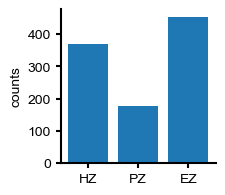

In [45]:
values_npe, counts_npe = torch.unique(npe_optimal_action, return_counts=True)
fig, ax = plt.subplots(1,1, figsize=(2,2))
plt.bar(["HZ","PZ","EZ"], counts_npe)
plt.ylabel("counts")
plt.show()

#### Predictions (joint plot)

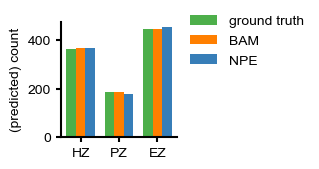

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(1.5,1.5))
width = 0.25  # the width of the bars
multiplier = 0

for counts,c, label in zip([counts_true, counts_nn, counts_npe], [color_post, color_nn, color_npe], ["ground truth", "BAM", "NPE"]):
    ax.bar(torch.arange(3).numpy() + width*multiplier, counts, color=c, width=width, label=label)
    multiplier += 1
ax.set_ylabel("(predicted) count")
ax.set_xticks(torch.arange(3).numpy() + width, ["HZ", "PZ", "EZ"])
ax.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=True, ncol=3)
plt.savefig('./paper/fig5/panel_appendix.svg')
plt.show()

#### Predictions

In [47]:
if generate_new_dataset:
    num_simulations = [500, 1_000, 5_000, 10_000, 50_000, 100_000]
    nn_optimal_actions = torch.empty((len(seeds), len(num_simulations),  num_new))
    npe_optimal_actions = torch.empty((len(seeds), len(num_simulations), num_new))

    for si, s in enumerate(seeds):
        print("seed", s)
        for i, nsim in enumerate(num_simulations):
            print(f"trained with {nsim} simulations")
            nn = models_allseeds[si][num_simulations_nn.index(nsim)]
            npe_posterior = npe_posteriors_allseeds[si][num_simulations_npe.index(nsim)]

            num_npe_samples = 500

            nn_predictions_all_actions = torch.hstack(
                [
                    nn(
                        observations_new.to(torch.float32),
                        a * torch.ones((observations_new.shape[0], 1)),
                    ).detach()
                    for a in [0.0, 1.0, 2.0]
                ]
            )
            npe_costs_all_a = []
            for a in [0, 1, 2]:
                npe_costs = []
                for x in tqdm(observations_new):
                    npe_samples = npe_posterior.sample(
                        (num_npe_samples,), x=x, show_progress_bars=False
                    )
                    npe_expected_costs = expected_posterior_costs_given_posterior_samples(
                        post_samples=npe_samples[:, 0:1],
                        actions=bvep.actions,
                        a=a * torch.ones((1,)),
                        param=0,
                        cost_fn=cost_fn,
                    ).squeeze()
                    npe_costs.append(npe_expected_costs)
                npe_costs_all_a.append(torch.stack(npe_costs))

            npe_costs_all_a = torch.vstack(npe_costs_all_a).T
            npe_optimal_action_seed = npe_costs_all_a.argmin(dim=1).unsqueeze(1)
            nn_optimal_action_seed = nn_predictions_all_actions.argmin(dim=1).unsqueeze(1)
            nn_optimal_actions[si, i] = nn_optimal_action_seed.squeeze(1)
            npe_optimal_actions[si, i] = npe_optimal_action_seed.squeeze(1)

            print("npe_optimal_action", npe_optimal_action_seed.shape)
            print("gt_actions", gt_actions.shape)
            print((npe_optimal_action_seed == gt_actions).shape)
            print("theta_new[:, 0:1]", theta_new[:, 0:1].shape)

            print(
                f"NPE correct predictions: {(npe_optimal_action_seed == gt_actions).sum()}/{num_new}"
            )
            print(
                f"NPE mean incurred costs: {cost_fn(theta_new[:, 0:1], npe_optimal_action_seed).mean():.6f}"
            )
            for a in range(3):
                print(
                    f"- action {a}: {cost_fn(theta_new[:, 0:1], npe_optimal_action_seed)[gt_actions==a].mean():.6f}"
                )

            print(
                f"NN correct predictions: {(nn_optimal_action_seed == gt_actions).sum()}/{num_new}"
            )
            print(
                f"NN mean incurred costs: {cost_fn(theta_new[:, 0:1], nn_optimal_action_seed).mean():.6f}"
            )
            for a in range(3):
                print(
                    f"- action {a}: {cost_fn(theta_new[:, 0:1], nn_optimal_action_seed)[gt_actions==a].mean():.6f}"
                )
        torch.save(npe_optimal_actions[:si+1], './paper/fig5/data/npe_optimal_actions.pt')
        torch.save(nn_optimal_actions[:si+1], './paper/fig5/data/nn_optimal_actions.pt')
else:
    print("here")
    npe_optimal_actions = torch.load('./paper/fig5/data/npe_optimal_actions.pt')
    nn_optimal_actions = torch.load('./paper/fig5/data/nn_optimal_actions.pt')


here


In [ ]:
# majority vote (mode)
repeated_gt_actions =  gt_actions.repeat(1, len(num_simulations)).T.repeat(len(seeds),1,1)
correct_pred_nn, _ = (nn_optimal_actions == repeated_gt_actions).mode(dim=0)
correct_pred_npe, _ = (npe_optimal_actions == repeated_gt_actions).mode(dim=0)
_, counts_true_classes = torch.unique(gt_actions, return_counts=True)


fig, ax = plt.subplots(1, 1, figsize=(1.5,1.5))
width = 0.25  # the width of the bars
multiplier = 0

for counts,c, label in zip([counts_true_classes, correct_pred_nn.sum(dim=1), correct_pred_npe.sum(dim=1)], [color_post, color_nn, color_npe], ["ground truth", "BAM", "NPE"]):
    ax.bar(torch.arange(3).numpy() + width*multiplier, counts, color=c, width=width, label=label)
    multiplier += 1
ax.set_ylabel("(predicted) count")
ax.set_xticks(torch.arange(3).numpy() + width, ["HZ", "PZ", "EZ"])
ax.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

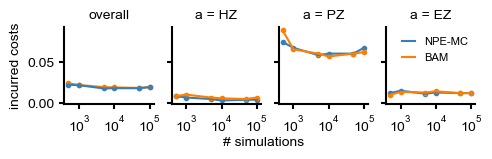

In [53]:
num_simulations = [500, 1000, 5000, 10000, 50000, 100000]
repeated_eta =  theta_new[:, 0:1].repeat(1,len(num_simulations)).T.repeat(len(seeds),1,1)
nn_incurred_costs = cost_fn(repeated_eta,nn_optimal_actions).mean(dim=0)
npe_incurred_costs =  cost_fn(repeated_eta,npe_optimal_actions).mean(dim=0)
action_labels = ["HZ", "PZ", "EZ"]

fig, axes = plt.subplots(1, num_actions+1, figsize=(5.3,1), sharex=True, sharey=True)
axes[0].set_xscale("log")
axes[0].set_xticks([100, 1000, 10000, 100000])
axes[0].get_xaxis().set_tick_params(which="minor", size=0)
axes[0].set_xticklabels([r"$10^2$", r"$10^3$", r"$10^4$", r"$10^5$"])
fig.text(0.5, -0.31,"# simulations", ha="center")
# axes[0].set_xlabel("# simulations")
axes[0].set_ylabel("incurred costs")


for col in range(num_actions+1):
    if col==0:
        axes[0].set_title("overall")
        axes[0].plot(num_simulations, nn_incurred_costs.mean(dim=1), color=color_nn, label=f"BAM")
        axes[0].plot(num_simulations, npe_incurred_costs.mean(dim=1), color=color_npe, label=f"NPE-MC")
        axes[0].scatter(num_simulations, nn_incurred_costs.mean(dim=1), color=color_nn)
        axes[0].scatter(num_simulations, npe_incurred_costs.mean(dim=1), color=color_npe)
    else:
        axes[col].set_title(f"a = {action_labels[col-1]}")
        axes[col].set_xticks([100, 1000, 10000, 100000])
        axes[col].get_xaxis().set_tick_params(which="minor", size=0)
        axes[col].set_xticklabels([r"$10^2$", r"$10^3$", r"$10^4$", r"$10^5$"])
        axes[col].scatter(num_simulations, npe_incurred_costs[:, (gt_actions==col-1).squeeze()].mean(dim=1), color=color_npe)
        axes[col].plot(num_simulations, npe_incurred_costs[:, (gt_actions==col-1).squeeze()].mean(dim=1), color=color_npe, label=f"NPE-MC")
        axes[col].scatter(num_simulations, nn_incurred_costs[:, (gt_actions==col-1).squeeze()].mean(dim=1), color=color_nn)
        axes[col].plot(num_simulations, nn_incurred_costs[:, (gt_actions==col-1).squeeze()].mean(dim=1), color=color_nn, label=f"BAM")

axes[3].legend(loc='upper left', bbox_to_anchor=(0.07, 1.0), handlelength=1.15, fontsize="8")
plt.savefig('./paper/fig5/panel_d.svg')
plt.show()


## Combine figures to one multipanel figure

In [92]:
import time
import IPython.display as IPd
from svgutils.compose import *

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_title = {'size': '10pt', 'font': 'Arial', 'weight': '500'}

f = Figure("21.59cm", "10.5cm", #20.3 = width of document (check!)
           
    Panel(
          SVG("./paper/fig5/panel_a.svg").scale(svg_scale),
          Text("a", 10., 2.0, **kwargs_text),
          Text("Observations and NPE predictives", 95., 2.0, **kwargs_title),
    ).move(0, 20),
    
    Panel(
          SVG("./paper/fig5/panel_b.svg").scale(svg_scale),
          Text("b", 5., 2.0, **kwargs_text),
          Text("Cost function", 80., 2.0, **kwargs_title),
    ).move(360, 20),
    
    Panel(
          SVG("./paper/fig5/panel_c.svg").scale(svg_scale),
          Text("c", 5., 2.0, **kwargs_text),
          Text("NPE posterior estimate", 35., 2.0, **kwargs_title),
    ).move(590, 20),
    
    Panel(
          SVG("./paper/fig5/panel_d.svg").scale(svg_scale),
          Text("d", 10., 2.0, **kwargs_text),
          Text("Comparison of incurred costs", 130., 2.0, **kwargs_title),
    ).move(360, 260),
)

f

In [94]:
import time
import IPython.display as IPd
from svgutils.compose import *

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_title = {'size': '10pt', 'font': 'Arial', 'weight': '500'}

f = Figure("21.59cm", "10.9cm", #20.3 = width of document (check!)
           
    Panel(
          SVG("./paper/fig5/panel_a.svg").scale(svg_scale),
          Text("a", 10., 2.0, **kwargs_text),
          Text("Observations and NPE predictives", 95., 2.0, **kwargs_title),
    ).move(0, 20),
    
    Panel(
          SVG("./paper/fig5/panel_c.svg").scale(svg_scale),
          Text("b", 5., 2.0, **kwargs_text),
          Text("NPE posterior estimate", 35., 2.0, **kwargs_title),
    ).move(360, 20),
    
    Panel(
          SVG("./paper/fig5/panel_b.svg").scale(svg_scale),
          Text("c", 5., 2.0, **kwargs_text),
          Text("Cost function", 80., 2.0, **kwargs_title),
          
    ).move(590, 20),
    
    Panel(
          SVG("./paper/fig5/panel_d.svg").scale(svg_scale),
          Text("d", 10., 2.0, **kwargs_text),
          Text("Comparison of incurred costs", 130., 2.0, **kwargs_title),
    ).move(360, 278),
)

f

In [95]:
f.save("./paper/fig5/fig5.svg")